In [ ]:
!pip install pyspark

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NYPD Complaint Data Analysis") \
    .getOrCreate()

### Data Preprocessing and cleaning

In [2]:
df = spark.read.csv('NYPD_Complaint_Data_Historic_20231205.csv', header=True, inferSchema=True)

# List of columns to drop
columns_to_drop = [
    'CMPLNT_NUM',     # Unique complaint number  
    'LOC_OF_OCCUR_DESC',  # Location of occurrence description
    'PREM_TYP_DESC',  # Premises type description
    'JURIS_DESC',     # They are all the same
    'HOUSING_PSA',    # Null
    'HADEVELOPT',
    'JURISDICTION_CODE',
    'TRANSIT_DISTRICT',
    'STATION_NAME',
    'Lat_Lon',
    'PARKS_NM',
]

# Drop the columns
df = df.drop(*columns_to_drop)

df = df.coalesce(1)

df.write.csv('bigdata_csv_preprocessed', header=True, mode='overwrite')

import pandas as pd
from pyspark.sql.functions import col

precinct_to_area_df = spark.read.csv('NYPD_Precincts_Areas_Final.csv', header=True, inferSchema=True)
df = df.join(precinct_to_area_df, df['ADDR_PCT_CD'] == precinct_to_area_df['Precinct Number'], 'left')
df.write.csv('updated_dataframe', mode = 'overwrite')

### Preview of the Data Frame

In [3]:
df.show()

+------------+------------+------------+------------+-----------+----------+-----+--------------------+-----+--------------------+----------------+-----------+---------+----------+----------+--------------+--------------------+--------+----------------+-----------------+--------------------+-------------+--------------------+-------+---------------+------------------+
|CMPLNT_FR_DT|CMPLNT_FR_TM|CMPLNT_TO_DT|CMPLNT_TO_TM|ADDR_PCT_CD|    RPT_DT|KY_CD|           OFNS_DESC|PD_CD|             PD_DESC|CRM_ATPT_CPTD_CD| LAW_CAT_CD|  BORO_NM|X_COORD_CD|Y_COORD_CD|SUSP_AGE_GROUP|           SUSP_RACE|SUSP_SEX|        Latitude|        Longitude|         PATROL_BORO|VIC_AGE_GROUP|            VIC_RACE|VIC_SEX|Precinct Number|              Area|
+------------+------------+------------+------------+-----------+----------+-----+--------------------+-----+--------------------+----------------+-----------+---------+----------+----------+--------------+--------------------+--------+----------------+-----

In [4]:
df.createOrReplaceTempView("crime_data")

### 1. Most Dangerous Area in NYC

In [5]:
total_crimes_by_area = spark.sql("""
    SELECT Area, COUNT(*) AS TotalCrimeCount
    FROM crime_data
    GROUP BY Area
    ORDER BY TotalCrimeCount DESC
""")

total_crimes_by_area.show()

most_dangerous_area_total_crimes = spark.sql("""
    SELECT Area, COUNT(*) AS TotalCrimeCount
    FROM crime_data
    GROUP BY Area
    ORDER BY TotalCrimeCount DESC
    LIMIT 1
""")

most_dangerous_area_total_crimes.show()

+--------------------+---------------+
|                Area|TotalCrimeCount|
+--------------------+---------------+
|             Jamaica|         270127|
|       East New York|         267545|
|     Lower East Side|         246324|
|  Bedford Stuyvesant|         232118|
|         East Harlem|         221750|
|           Soundview|         212841|
|          Highbridge|         207083|
|             Chelsea|         203549|
|      Central Harlem|         201727|
|             Melrose|         200673|
|Midtown Business ...|         190124|
|     Stuyvesant Town|         180158|
|  University Heights|         174376|
|        Bedford Park|         172975|
|         Brownsville|         168821|
|        Williamsburg|         168687|
|  Washington Heights|         167740|
|            Canarsie|         164564|
|           Wakefield|         160222|
|           Stapleton|         159577|
+--------------------+---------------+
only showing top 20 rows

+-------+---------------+
|   Area|Tot

### Plot

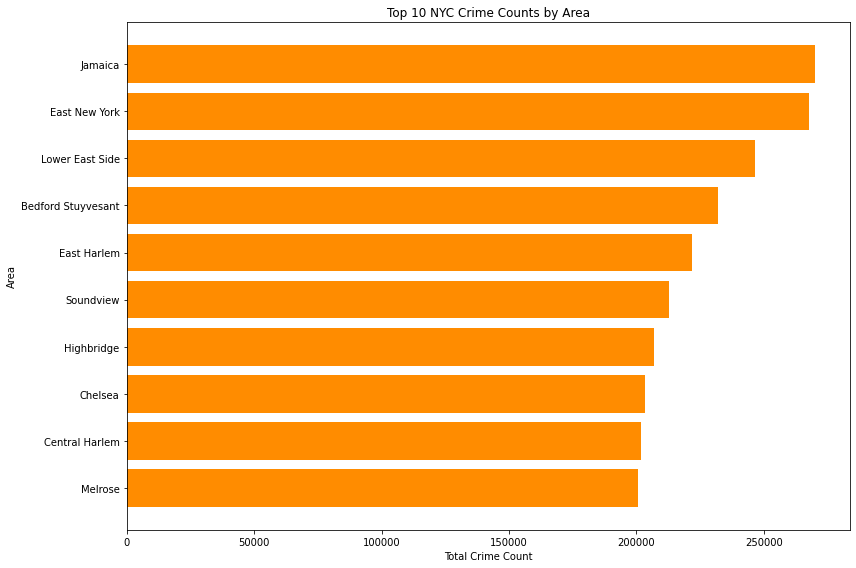

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for the top 10 areas with the most crimes
top10_areas = [
    "Jamaica", "East New York", "Lower East Side", "Bedford Stuyvesant",
    "East Harlem", "Soundview", "Highbridge", "Chelsea",
    "Central Harlem", "Melrose"
]
top10_crime_counts = [
    270127, 267545, 246324, 232118, 221750, 212841, 207083, 203549,
    201727, 200673
]

# Create a horizontal bar chart for the top 10 areas
plt.figure(figsize=(12, 8))
plt.barh(top10_areas, top10_crime_counts, color='darkorange')
plt.xlabel('Total Crime Count')
plt.ylabel('Area')
plt.title('Top 10 NYC Crime Counts by Area')
plt.gca().invert_yaxis()  # To display the highest count at the top
plt.tight_layout()
plt.show()

### 2. Safest Area in NYC

In [7]:
safest_area_least_crime = spark.sql("""
    SELECT Area, COUNT(*) AS TotalCrimeCount
    FROM crime_data
    GROUP BY Area
    ORDER BY TotalCrimeCount ASC
    LIMIT 11
""")

safest_area_least_crime.show()

+-----------------+---------------+
|             Area|TotalCrimeCount|
+-----------------+---------------+
|      Tottenville|          50995|
|          Bayside|          52928|
|     Forest Hills|          61151|
|             NULL|          65374|
|        Riverdale|          78001|
|     Borough Park|          79073|
|        Bay Ridge|          83621|
|    Fresh Meadows|          89000|
|        Sunnyside|          89509|
|Greenwich Village|          90604|
|      Sunset Park|          91519|
+-----------------+---------------+



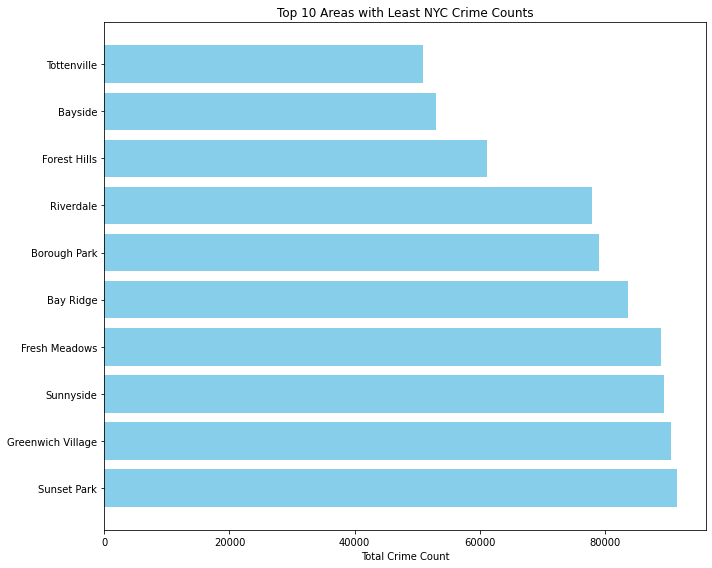

In [8]:
import matplotlib.pyplot as plt

# Data for the top 10 areas with the least crimes
areas = [
    "Tottenville", "Bayside", "Forest Hills", "Riverdale",
    "Borough Park", "Bay Ridge", "Fresh Meadows", "Sunnyside",
    "Greenwich Village", 'Sunset Park'
]
crime_counts = [
    50995, 52928, 61151, 78001, 79073, 83621, 89000, 89509, 90604, 91519
]

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(areas, crime_counts, color='skyblue')
plt.xlabel('Total Crime Count')
plt.title('Top 10 Areas with Least NYC Crime Counts')
plt.gca().invert_yaxis()  # To display the lowest count at the top
plt.tight_layout()
plt.show()


### 3. Age of Victim

In [9]:
crimes_by_victim_age = spark.sql("""
    SELECT VIC_AGE_GROUP, COUNT(*) AS CrimesCount
    FROM crime_data
    WHERE VIC_AGE_GROUP IN ('<18', '18-24', '25-44', '45-64', '65+')
    GROUP BY VIC_AGE_GROUP
    ORDER BY CrimesCount DESC
""")

In [10]:
crimes_by_victim_age.show()

+-------------+-----------+
|VIC_AGE_GROUP|CrimesCount|
+-------------+-----------+
|        25-44|    2773911|
|        45-64|    1437379|
|        18-24|     856564|
|          <18|     396009|
|          65+|     299823|
+-------------+-----------+



In [ ]:
!pip install matplotlib seaborn

<ipython-input-11-83b88f9fe71f>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


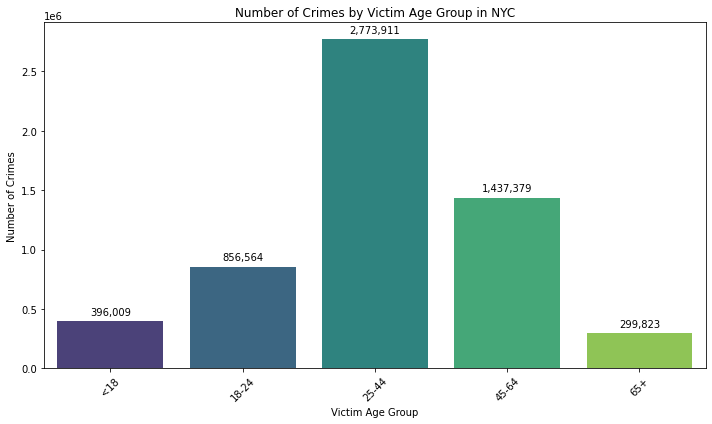

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data provided, reordered by age group in ascending order
crime_counts = pd.DataFrame({
    'VIC_AGE_GROUP': ['<18', '18-24', '25-44', '45-64', '65+'],
    'CrimesCount': [396009, 856564, 2773911, 1437379, 299823]
})

# Plotting the data
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=crime_counts, 
    x='VIC_AGE_GROUP', 
    y='CrimesCount', 
    palette='viridis', 
    order=['<18', '18-24', '25-44', '45-64', '65+']
)
plt.title('Number of Crimes by Victim Age Group in NYC')
plt.xlabel('Victim Age Group')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)

# Adding the count above the bars
for p in barplot.patches:
    barplot.annotate(
        f'{int(p.get_height()):,}',  # Using a comma as a thousand separator
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='center', 
        xytext=(0, 9), 
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

### Number of crimes committed in each borough in NYC

In [12]:
# Aggregate the number of crimes by borough excluding NULL values
crimes_by_borough = spark.sql("""
    SELECT BORO_NM, COUNT(*) AS CrimeCount
    FROM crime_data
    WHERE BORO_NM IS NOT NULL
    GROUP BY BORO_NM
""")

# Convert to a Pandas DataFrame
crimes_by_borough_df = crimes_by_borough.toPandas()

In [ ]:
!pip install folium

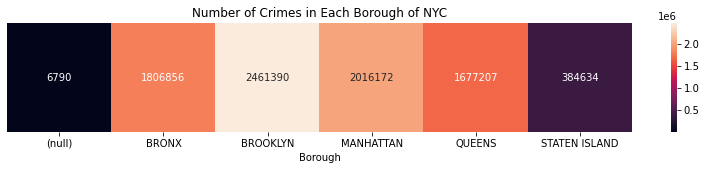

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

crimes_by_borough_df = crimes_by_borough.toPandas()
crimes_by_borough_df = crimes_by_borough_df[crimes_by_borough_df['BORO_NM'].notnull()]
crimes_by_borough_df.sort_values('BORO_NM', inplace=True)

heatmap_data = [crimes_by_borough_df['CrimeCount'].tolist()]

plt.figure(figsize=(14, 2))
sns.heatmap(heatmap_data, annot=True, fmt="d", yticklabels=False, xticklabels=crimes_by_borough_df['BORO_NM'].tolist())
plt.title('Number of Crimes in Each Borough of NYC')
plt.xlabel('Borough')
plt.show()

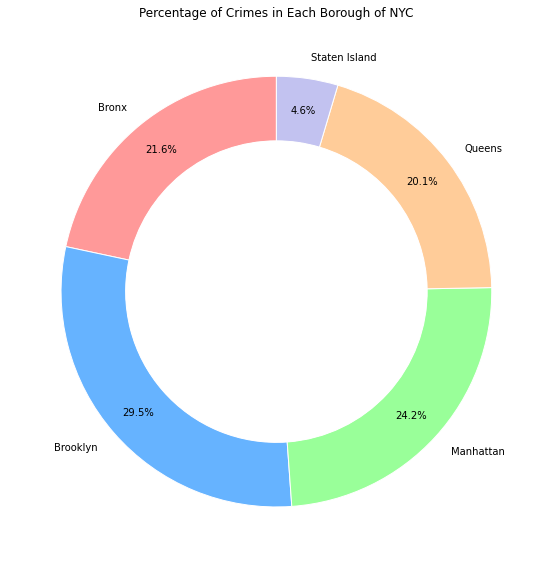

In [14]:
import matplotlib.pyplot as plt

# Data from the provided image, excluding 'NULL'
boroughs = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
crime_counts = [1806856, 2461390, 2016172, 1677207, 384634]

# Define colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

# Create a pie chart with a donut style
plt.figure(figsize=(8, 8))
plt.pie(crime_counts, labels=boroughs, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, 
        wedgeprops=dict(width=0.3, edgecolor='w'))

# Draw a circle at the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Percentage of Crimes in Each Borough of NYC')
plt.tight_layout()
plt.show()


### Stats of highest type of crime committed in a particular Area

In [15]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

crime_counts = df.groupBy("Area", "LAW_CAT_CD").count()

windowSpec = Window.partitionBy("LAW_CAT_CD").orderBy(F.col("count").desc())

top_crime_areas = crime_counts.withColumn("rank", F.row_number().over(windowSpec)) \
                             .filter(F.col("rank") == 1) \
                             .drop("rank")

top_crime_areas.show()

+-------------+-----------+------+
|         Area| LAW_CAT_CD| count|
+-------------+-----------+------+
|      Jamaica|     FELONY| 94578|
|East New York|MISDEMEANOR|145373|
|      Jamaica|  VIOLATION| 33923|
+-------------+-----------+------+



In [16]:
top_crime_areas_df = top_crime_areas.toPandas()

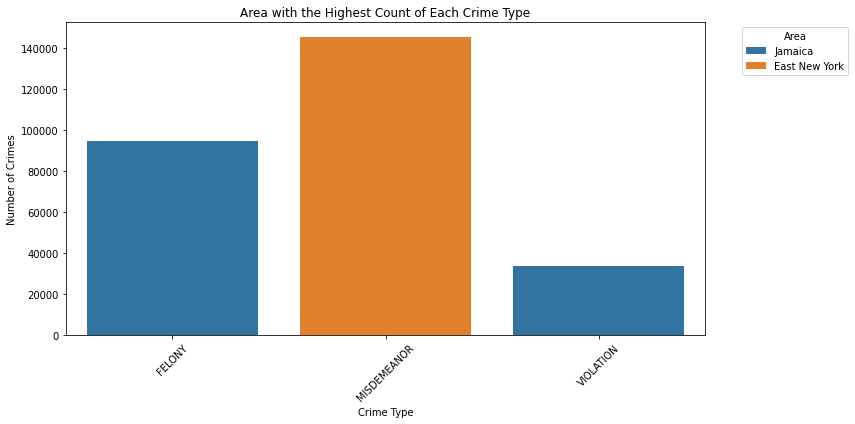

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the results
plt.figure(figsize=(12, 6))
sns.barplot(data=top_crime_areas_df, x='LAW_CAT_CD', y='count', hue='Area')
plt.title('Area with the Highest Count of Each Crime Type')
plt.xlabel('Crime Type')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.legend(title='Area', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Highest Suspect Race w.r.t Area

In [18]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

filtered_df = df.filter((df.Area.isNotNull()) & 
                        (df.SUSP_RACE.isNotNull()) & 
                        (df.SUSP_RACE != '(null)'))

race_counts = filtered_df.groupBy("Area", "SUSP_RACE").count()
windowSpec = Window.partitionBy("Area").orderBy(F.col("count").desc())
top_race_by_area = race_counts.withColumn("rank", F.row_number().over(windowSpec)) \
                              .filter(F.col("rank") == 1) \
                              .drop("rank")
top_race_by_area.show()

+-------------------+---------+-----+
|               Area|SUSP_RACE|count|
+-------------------+---------+-----+
|            Astoria|  UNKNOWN|29487|
|       Battery Park|    BLACK|20751|
|          Bay Ridge|    WHITE|18469|
|            Bayside|    WHITE| 7092|
|       Bedford Park|  UNKNOWN|30566|
| Bedford Stuyvesant|    BLACK|86950|
|        Bensonhurst|    WHITE|21917|
|       Borough Park|  UNKNOWN|18099|
|   Brooklyn Heights|    BLACK|44206|
|        Brownsville|    BLACK|64339|
|           Bushwick|    BLACK|20497|
|           Canarsie|    BLACK|58708|
|     Central Harlem|    BLACK|72729|
|            Chelsea|  UNKNOWN|35707|
|       Coney Island|  UNKNOWN|22896|
|Crown Heights North|    BLACK|42111|
|Crown Heights South|    BLACK|43152|
|      East Flatbush|    BLACK|69399|
|        East Harlem|    BLACK|55738|
|      East New York|    BLACK|78177|
+-------------------+---------+-----+
only showing top 20 rows



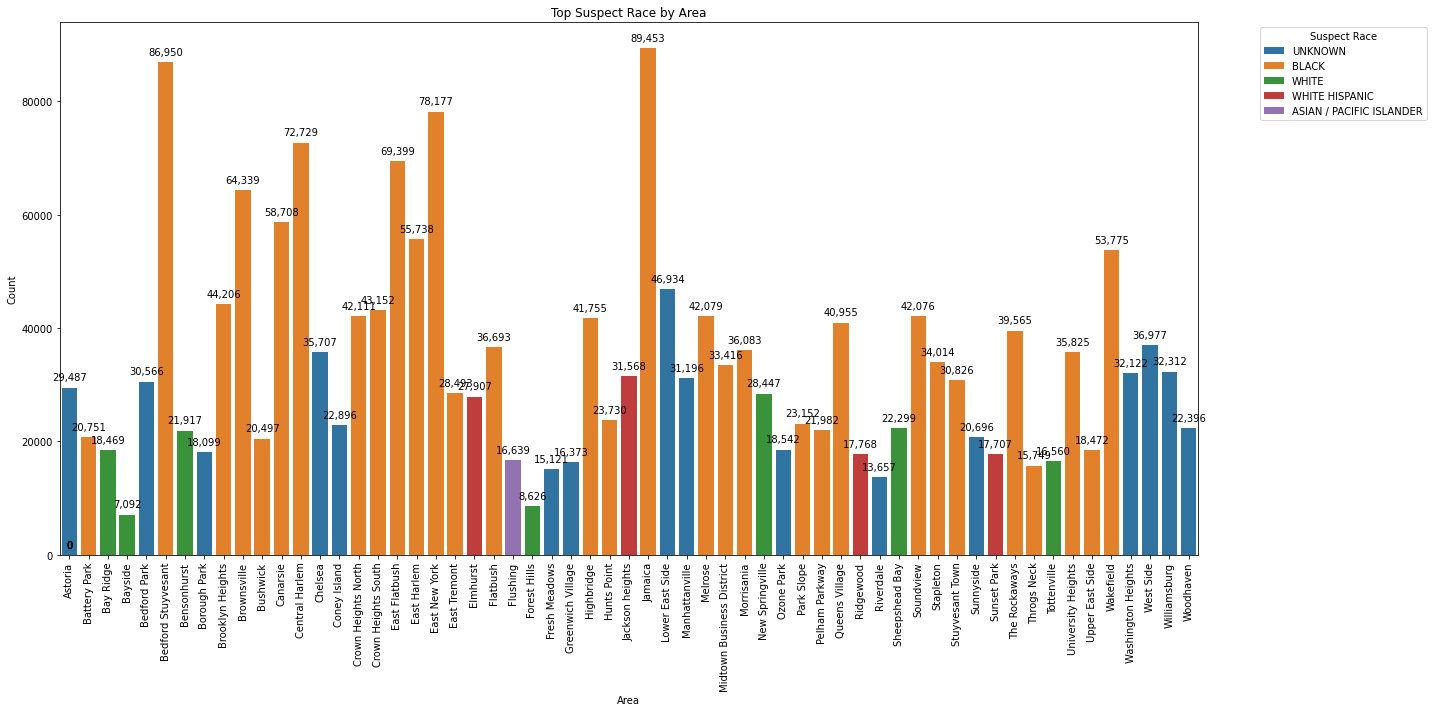

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


plt.figure(figsize=(20, 10)) 
top_race_by_area_df = top_race_by_area.toPandas()
barplot = sns.barplot(data=top_race_by_area_df, x='Area', y='count', hue='SUSP_RACE')

plt.xticks(rotation=90)

for p in barplot.patches:
    height = p.get_height()
    if not np.isnan(height):
        barplot.annotate(f'{height:,.0f}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center',
                         xytext=(0, 10), textcoords='offset points')

plt.title('Top Suspect Race by Area')
plt.xlabel('Area')
plt.ylabel('Count')
plt.legend(title='Suspect Race', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.show()

### Highest Victim Race w.r.t Area

In [20]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

filtered_df = df.filter(df.VIC_RACE.isNotNull())
victim_race_counts = filtered_df.groupBy("Area", "VIC_RACE").count()
windowSpec = Window.partitionBy("Area").orderBy(F.col("count").desc())
top_victim_race_by_area = victim_race_counts.withColumn("rank", F.row_number().over(windowSpec)) \
                                            .filter(F.col("rank") == 1) \
                                            .drop("rank")

top_victim_race_by_area.show()

+-------------------+--------------+------+
|               Area|      VIC_RACE| count|
+-------------------+--------------+------+
|               NULL|       UNKNOWN| 21954|
|            Astoria|         WHITE| 44692|
|       Battery Park|       UNKNOWN| 55558|
|          Bay Ridge|         WHITE| 37688|
|            Bayside|         WHITE| 21539|
|       Bedford Park|       UNKNOWN| 64698|
| Bedford Stuyvesant|         BLACK|113277|
|        Bensonhurst|         WHITE| 44081|
|       Borough Park|         WHITE| 31590|
|   Brooklyn Heights|       UNKNOWN| 58940|
|        Brownsville|         BLACK| 87553|
|           Bushwick|WHITE HISPANIC| 37844|
|           Canarsie|         BLACK| 84753|
|     Central Harlem|         BLACK| 84575|
|            Chelsea|       UNKNOWN| 83425|
|       Coney Island|         WHITE| 33795|
|Crown Heights North|         BLACK| 60133|
|Crown Heights South|         BLACK| 63608|
|      East Flatbush|         BLACK|105375|
|        East Harlem|       UNKN

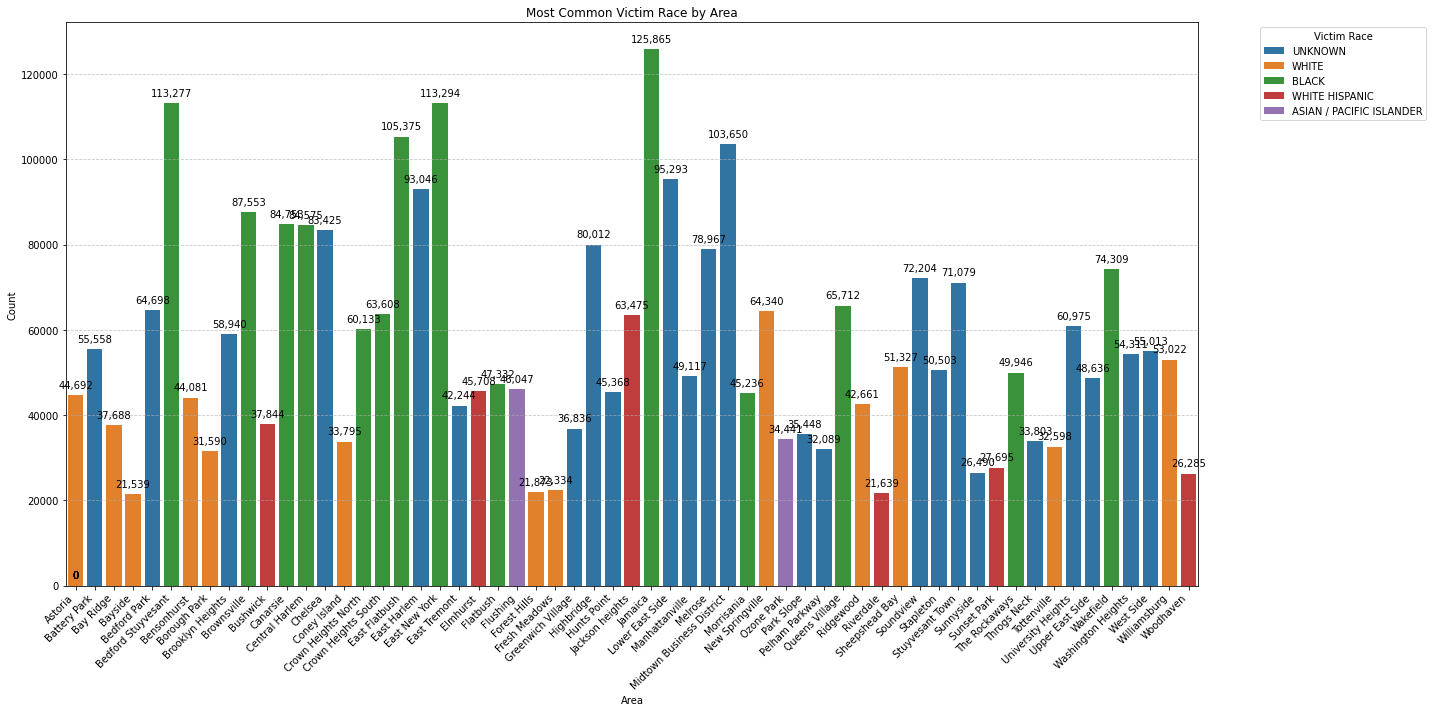

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


plt.figure(figsize=(20, 10)) 
top_victim_race_by_area_df = top_victim_race_by_area.toPandas()
barplot = sns.barplot(data=top_victim_race_by_area_df, x='Area', y='count', hue='VIC_RACE', dodge=False)
plt.xticks(rotation=45, ha='right')

for p in barplot.patches:
    barplot.annotate(format(int(p.get_height()), ','),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 10), textcoords='offset points')

plt.title('Most Common Victim Race by Area')
plt.xlabel('Area')
plt.ylabel('Count')
plt.legend(title='Victim Race', bbox_to_anchor=(1.05, 1), loc='upper left') 

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Prediction of what type of crime committed in which area

In [22]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

categoricalColumns = ['OFNS_DESC', 'BORO_NM', 'CRM_ATPT_CPTD_CD'] 

indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categoricalColumns]
encoders = [OneHotEncoder(inputCols=[col + "_index"], outputCols=[col + "_encoded"]) for col in categoricalColumns]
assembledInputs = [col + "_encoded" for col in categoricalColumns] + ['Latitude', 'Longitude']
vecAssembler = VectorAssembler(inputCols=assembledInputs, outputCol="features")
labelIndexer = StringIndexer(inputCol="LAW_CAT_CD", outputCol="label")

rf = RandomForestClassifier(labelCol="label", featuresCol="features")

pipeline = Pipeline(stages=indexers + encoders + [vecAssembler, labelIndexer, rf])

df_filled = df.fillna('unknown', subset=categoricalColumns)  
df_filled = df_filled.fillna({'Latitude': 0, 'Longitude': 0})

# Train/test split
(train_df, test_df) = df_filled.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_df)
predictions = model.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % accuracy)

Test Accuracy = 0.874805


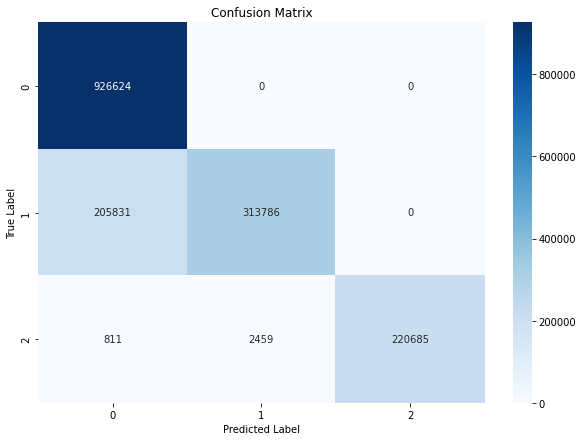

In [30]:
from pyspark.sql.functions import col
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns

predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)
conf_matrix = metrics.confusionMatrix().toArray()

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


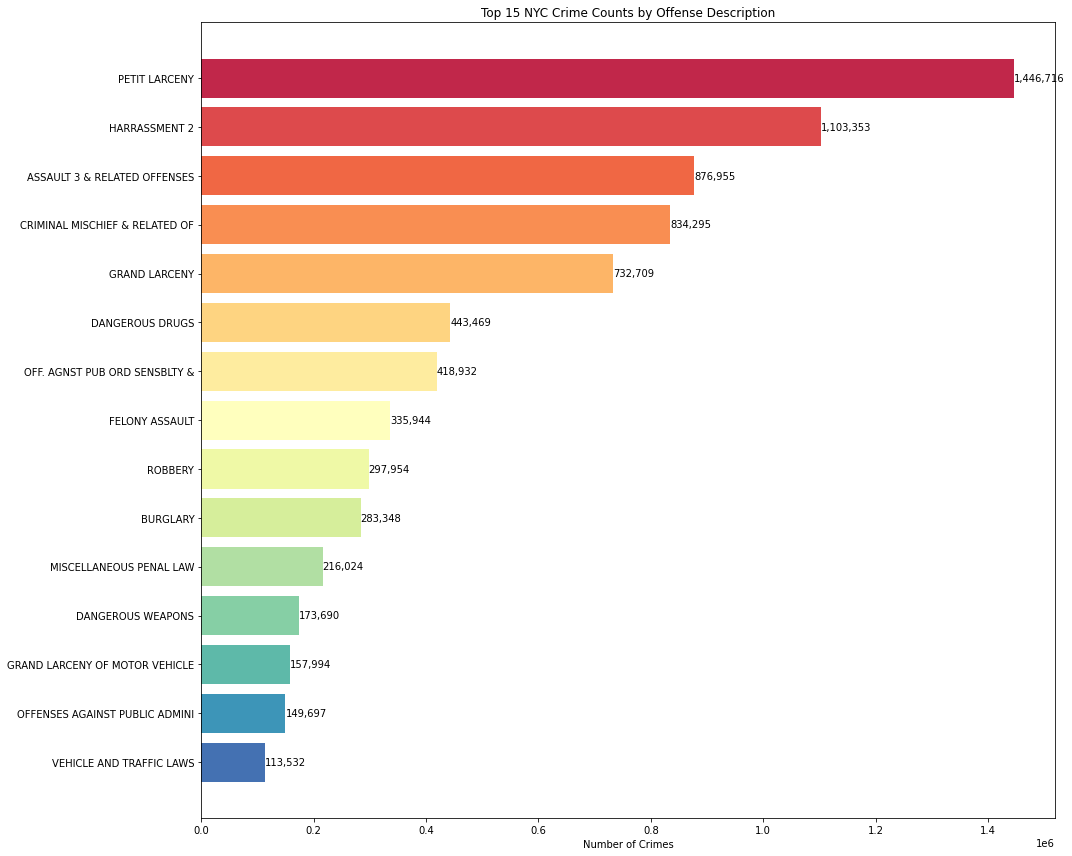

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data from the provided information
offense_descriptions = [
    'PETIT LARCENY',
    'HARRASSMENT 2',
    'ASSAULT 3 & RELATED OFFENSES',
    'CRIMINAL MISCHIEF & RELATED OF',
    'GRAND LARCENY',
    'DANGEROUS DRUGS',
    'OFF. AGNST PUB ORD SENSBLTY &',
    'FELONY ASSAULT',
    'ROBBERY',
    'BURGLARY',
    'MISCELLANEOUS PENAL LAW',
    'DANGEROUS WEAPONS',
    'GRAND LARCENY OF MOTOR VEHICLE',
    'OFFENSES AGAINST PUBLIC ADMINI',
    'VEHICLE AND TRAFFIC LAWS'
]
crime_counts = [
    1446716,
    1103353,
    876955,
    834295,
    732709,
    443469,
    418932,
    335944,
    297954,
    283348,
    216024,
    173690,
    157994,
    149697,
    113532
]

# Set the color palette
colors = sns.color_palette('Spectral', n_colors=len(offense_descriptions))

# Create a horizontal bar chart
plt.figure(figsize=(15, 12))
barplot = plt.barh(offense_descriptions, crime_counts, color=colors)

# Add the data labels
for bar in barplot:
    plt.text(
        bar.get_width(), bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():,.0f}',  # Comma as thousand separator
        va='center', ha='left'
    )

plt.xlabel('Number of Crimes')
plt.title('Top 15 NYC Crime Counts by Offense Description')
plt.gca().invert_yaxis()  # To display the highest count at the top
plt.tight_layout()
plt.show()

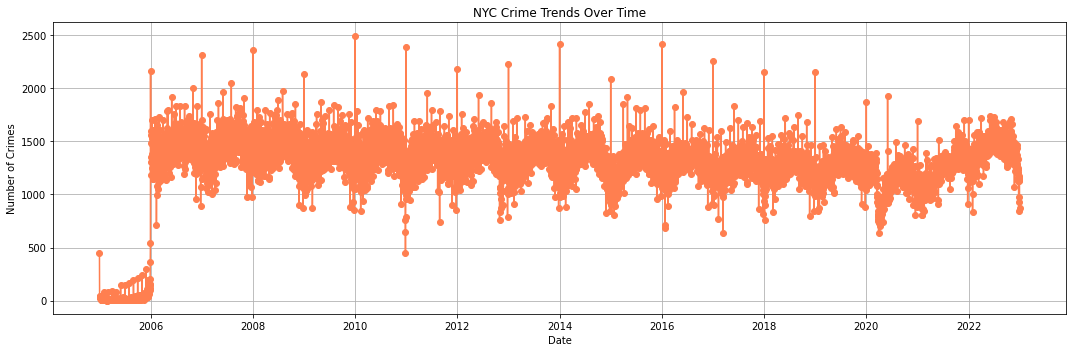

In [24]:
from pyspark.sql.functions import to_date
# Filter out invalid dates
df_filtered = df.filter(to_date(df['CMPLNT_FR_DT'], 'MM/dd/yyyy').cast('timestamp') >= '2005-01-01')

# Convert 'CMPLNT_FR_DT' column to date type
df_with_date = df_filtered.withColumn('Complaint_Date', to_date(df_filtered['CMPLNT_FR_DT'], 'MM/dd/yyyy'))

# Aggregate crime data by date
crime_by_date = df_with_date.groupBy('Complaint_Date').count().orderBy('Complaint_Date').collect()

# Convert to Pandas DataFrame
crime_by_date_df = pd.DataFrame(crime_by_date, columns=["Complaint_Date", "Count"])

# Convert 'Complaint_Date' column to Pandas datetime
crime_by_date_df['Complaint_Date'] = pd.to_datetime(crime_by_date_df['Complaint_Date'])

# Create a time series plot with Matplotlib
plt.figure(figsize=(15, 5))
plt.plot(crime_by_date_df['Complaint_Date'], crime_by_date_df['Count'], marker='o', linestyle='-', color='coral')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.title('NYC Crime Trends Over Time')
plt.grid(True)
plt.tight_layout()
plt.savefig("NYC_Crime_Time_Series.png")
plt.show()